We are an agency helping our customers purchase XoX (a made-up product) from various makers. Price is one of the most important things we care about. We need to estimate the price of a XoX before we recommend it to our customers. However, the estimations vary significantly with our employees' experience. 

We would like you to build a machine learning model to accurately predict the price for a future purchase and provide insights to help us explain the predicted price to our customers. Please note that neither our customers nor us have any knowledge about machine learning. A sample of our sales record is available in ../data/sales.csv.


1. Preprocess, clean, analyze and visualized the provided data. A few sentences or plots describing your approach will suffice. Any thing you would like us to know about the price?
2. Build a machine learning model to help us determine the price for a purchase. Discuss why you choose the approaches, what alternatives you consider, and any concerns you have. How is the performance of your model?
3. Help us understand how the price is predicted (again, a few sentences will suffice).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [3]:
import util
import model

# 1. Preprocess, clean, analyze and visualized the data.

In [4]:
# read the data and transform the numerical data
# Because 'price' is the target, drop the rows with null price value
df = pd.read_csv('../../data/sales.csv')
df.dropna(subset=['price'], inplace=True)
df = util.Str2NumTransform().transform(df)

In [ ]:
df.head()

## 1.1 Data information

In [ ]:
# check the data information
util.data_info(df)

In [ ]:
# check the collinearity of numerical variables
util.plot_cor(df)

## 1.2 Summary of the data analysis and preprocess  

### 1. The variable type
- Numerical data: 'cost', 'weight', 'height', 'width', 'depth'.
- Categorical data: 'product_type', 'product_level', 'maker', 'ingredient'. 

### 2. Numerical variables
- **Collinearity exists**: Highly correlated variables are width-depth, width-height and height-depth, and reasonably correlated variable is price-cost.
- 'cost' has many missing values, so using multiple variables rather than just 'cost' in the models can help improve the model performance.
- Missing values can be replaced by the mean value of each variable.  

### 3. Categorical variables
- The missing values in 'product_type' and 'product_level' are just 1 place, which can be ignored in building models.
- Variables of 'maker' and 'ingredient' have large number of missing values, and they show very complex categorical characteristics. It's better to drop those two variables in models or encode them in a simple way to reveal more information.


# 2. Machine learning models and performance

In [5]:
# data split to Train data and Test data
# learning from previous data to predict future data
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train = df[df.year < 2015].reset_index(drop=True)
test = df[df.year >= 2015].reset_index(drop=True)
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train = df[df.year < 2015].reset_index(drop=True)
test = df[df.year >= 2015].reset_index(drop=True)
y_train = train['price']
y_test = test['price']

## 2.1 Linear regression models
- Using numerical variables to predict 'price'

### 2.1.1. Feature selection: 'cost', 'weight'
- Using variables with or without collinearity, models showed the similar performance.
- Correlated variables ('heigh', 'width', 'depth') showed much smaller feature importance than 'cost' and 'weight' in the model. So statistically dropping them for the linear regression models statistically make sense.

### 2.1.2 Model selection
### (1) Linear regression

In [6]:
# Normal Linear Regression model
features_all = ['cost', 'weight', 'height', 'width', 'depth']
features = ['cost', 'weight']

numeric_transformer = Pipeline(
    steps=[('impute', SimpleImputer(strategy='mean'))]
)

preprocessor1 = ColumnTransformer(
    transformers=[('num', numeric_transformer, features_all)]
)
preprocessor2 = ColumnTransformer(
    transformers=[('num', numeric_transformer, features)]
)

step1 = [
    ('preprocessor', preprocessor1),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
]

step2 = [
    ('preprocessor', preprocessor2),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
]

models = {
    'LR_all-features': Pipeline(step1),
    'LR_noncorrelated-features': Pipeline(step2),
}

Pipeline(step1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer())]),
                                                  ['cost', 'weight', 'height',
                                                   'width', 'depth'])])),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [7]:
model.model_metrics(models, train, test, y_train, y_test)

,LR_all-features,LR_noncorrelated-features
MAE_train,1.143503e+05,1.143893e+05
MSE_train,2.869285e+10,2.872457e+10
r2_train,3.266459e-01,3.259017e-01
MAE_test,1.425154e+05,1.430183e+05
MSE_test,5.578572e+10,5.585776e+10
r2_test,3.529172e-01,3.520816e-01


,LR_all-features,LR_noncorrelated-features
Feature Importance,"[104835.32467687351, 37478.29871382135, -8998....","[104987.63656702708, 30509.635063277998]"


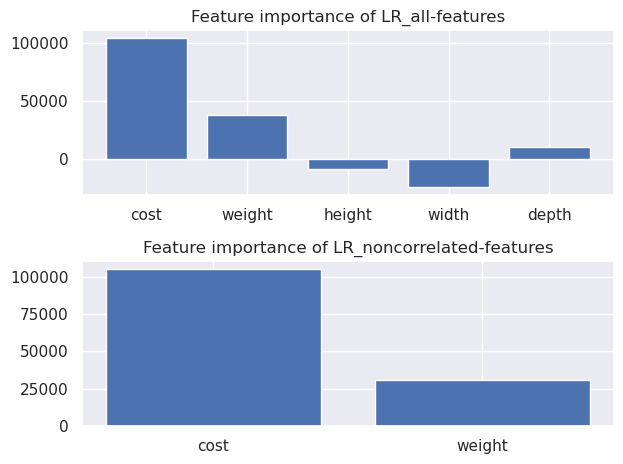

In [8]:
model.model_fi(models, train, y_train)

### (2) Polynomial regression with regularization
###       ----- Lasso and Ridge: Add regularization to the polynomial regression model
- Using polynomial features of 'cost' and 'weight', aiming for fitting the data better not just straight line.
- Using Lasso and Ridge regulariztion to reduce the dimensionality of polynomial features / overfitting.
- Tunning the hyperparameters of Polynomial features and regulariztion.
- Polynomial features perform a bit better than normal linear regression. But model still not perfect. 

In [9]:
features = ['cost', 'weight']

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, features)]
)

step1 = [
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()), # default degree=2
    ('scaler', StandardScaler()),
    ('regressor', Lasso(max_iter=1000000, tol=1))
]

step2 = [
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()), # default degree=2
    ('scaler', StandardScaler()),
    ('regressor', Ridge(max_iter=1000000, tol=1))
]

# tunning hyperparameters
param = {
    'poly__degree': range(2, 10),
    'regressor__alpha': np.linspace(0.1, 5, num=30)
}

models = {
    'Lasso_tuned': 
    model.model_tune(step1, param, train, y_train).best_estimator_,
    'Ridge_tuned': 
    model.model_tune(step2, param, train, y_train).best_estimator_
}

Pipeline(step1)

Tunning results:  {'poly__degree': 8, 'regressor__alpha': 0.1}
Tunning results:  {'poly__degree': 3, 'regressor__alpha': 0.9448275862068966}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer())]),
                                                  ['cost', 'weight'])])),
                ('poly', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('regressor', Lasso(max_iter=1000000, tol=1))])

In [10]:
Pipeline(step2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer())]),
                                                  ['cost', 'weight'])])),
                ('poly', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('regressor', Ridge(max_iter=1000000, tol=1))])

In [11]:
model_performance_1 = model.model_metrics(models, train, test, y_train, y_test)
model_performance_1

,Lasso_tuned,Ridge_tuned
MAE_train,1.114209e+05,1.082525e+05
MSE_train,2.788107e+10,2.708781e+10
r2_train,3.456966e-01,3.643126e-01
MAE_test,1.384731e+05,1.352948e+05
MSE_test,5.257221e+10,5.376591e+10
r2_test,3.901921e-01,3.763459e-01


,Lasso_tuned,Ridge_tuned
Feature Importance,"[0.0, 104703.26853542161, 27483.64374322426, 7...","[0.0, -3939.2707451427923, -42862.18921022747,..."


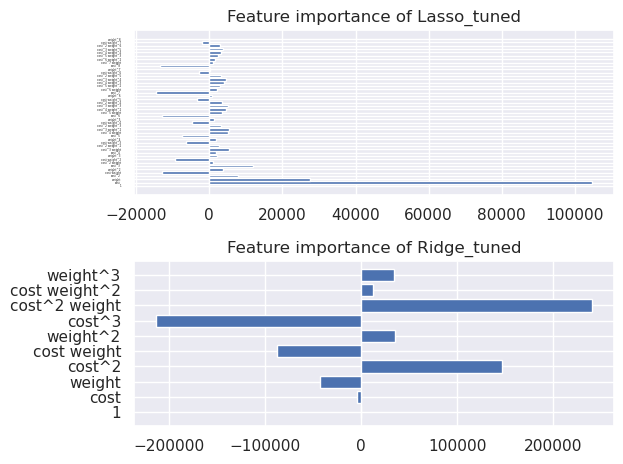

In [12]:
model.model_fi(models, train, y_train, features)
#models['LR_Lasso_tuned']['poly'].get_feature_names_out(features)

### 2.1.3 Feature selection: Numerical + Categorical features
- Numerical features: 'Cost', 'Weight'
- Categorical features: 'product_type', 'product_level', 'maker', 'ingredient'

### (1) Take a look at the categorical data 
### Simple encoding: 
- **product_level**: change to ordinal labels
- **product_type**: one hot encoder
- **maker**: Use the three digits to reduce the categories, i.e. M14122 --> M141, then ont hot encoding
- **ingredient**: count the number of ingredient, use the number as new variable

In [13]:
df['maker_new'] = df.maker.map(util.maker_change)
df['ingredient_new'] = df.ingredient.map(util.ingredient_change)
train = df[df.year < 2015].reset_index(drop=True)
test = df[df.year >= 2015].reset_index(drop=True)
y_train = train['price']
y_test = test['price']

In [20]:
df

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth,year,maker_new,ingredient_new
0,333000.0,300492.0,3090.0,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76,97.0,26.0,2008,M141,2
1,NaN,430570.0,3030.0,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67,98.0,26.0,1997,UnKnown,5
2,270000.0,213070.0,3040.0,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.00,93.0,24.0,2001,UnKnown,3
3,NaN,229174.0,3050.0,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.50,102.0,27.0,2016,M141,3
4,97000.0,122659.0,2970.0,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47,101.0,26.0,2000,UnKnown,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,NaN,93349.0,3000.0,Nov 25 2016,D,advanced,M14904,"IN732490,IN732338,IN732503,IN732435,IN732583",2.02,112.0,29.0,2016,M149,5
3193,NaN,40384.0,2830.0,May 25 2007,"J,B",intermediate,M14578,"IN732832,IN732166,IN733162,IN733785,IN732069,I...",2.15,106.0,28.0,2007,M145,6
3194,NaN,1074844.0,3080.0,Dec 16 2016,C,intermediate,"M14883,M15011","IN733462,IN732654,IN732149,IN733067,IN734088,I...",2.84,96.0,25.0,2016,M148M150,9
3195,44000.0,55931.0,2950.0,Apr 12 2002,R,advanced,M14341,IN732587,2.52,100.0,26.0,2002,M143,1


In [54]:
numeric_features = ['cost', 'weight']

categorical_features_1 = ['product_level', 'ingredient_new', 'maker_new']
categorical_features_2 = ['product_level', 'ingredient_new', 'maker_new', 'product_type']

product_level_ordinal = OrdinalEncoder(
    categories=[['unrated', 'basic', 'intermediate', 'advanced', 'super advanced']]
)

preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_level', product_level_ordinal, ['product_level']),
        ('cat_maker', OneHotEncoder(handle_unknown='ignore'), ['maker_new'])
    ], remainder='passthrough'
)

step_1 = [
    ('preprocessor', preprocessor_1),
    #('poly', PolynomialFeatures()), # default degree=2
    ('scaler', StandardScaler(with_mean=False)),
    ('regressor', LinearRegression())
]

features_1 = numeric_features + categorical_features_1
X_train_1 = train[features_1]
X_test_1 = test[features_1]

model_1 = {
    'LR_1': Pipeline(step_1),
}

Pipeline(step_1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cost', 'weight']),
                                                 ('cat_level',
                                                  OrdinalEncoder(categories=[['unrated',
                                                                              'basic',
                                                                              'intermediate',
                                                                              'advanced',
                                                                              'super '
                                                                              'advanced']]),
                                                  ['product_level']),
                                                 ('cat_maker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['maker_new'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('regressor', LinearRegression())])

In [55]:
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_level', product_level_ordinal, ['product_level']),
        ('cat_type', OneHotEncoder(handle_unknown='ignore'), ['product_type']),
        ('cat_maker', OneHotEncoder(handle_unknown='ignore'), ['maker_new'])
    ], remainder='passthrough'
)

step_2 = [
    ('preprocessor', preprocessor_2),
    #('poly', PolynomialFeatures()), # default degree=2
    ('scaler', StandardScaler(with_mean=False)),
    ('regressor', LinearRegression())
]

features_2 = numeric_features + categorical_features_2
X_train_2 = train[features_2]
X_test_2 = test[features_2]

model_2 = {
    'LR_2': Pipeline(step_2),
}

Pipeline(step_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cost', 'weight']),
                                                 ('cat_level',
                                                  OrdinalEncoder(categories=[['unrated',
                                                                              'basic',
                                                                              'intermediate',
                                                                              'advanced',
                                                                              'super '
                                                                              'advanced']]),
                                                  ['product_level']),
                                                 ('cat_type',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['product_type']),
                                                 ('cat_maker',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['maker_new'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('regressor', LinearRegression())])

In [16]:
model.model_metrics(model_1, X_train_1, X_test_1, y_train, y_test)

,LR_1
MAE_train,1.060556e+05
MSE_train,2.469459e+10
r2_train,4.204757e-01
MAE_test,1.408602e+05
MSE_test,5.136346e+10
r2_test,4.042129e-01


In [56]:
model_performance_5 = model.model_metrics(model_2, X_train_2, X_test_2, y_train, y_test)
model_performance_5

,LR_2
MAE_train,1.018043e+05
MSE_train,2.270464e+10
r2_train,4.671753e-01
MAE_test,1.334920e+05
MSE_test,4.634105e+10
r2_test,4.624700e-01


,LR_1
Feature Importance,"[81665.40702400949, 26373.80110289161, -27650...."


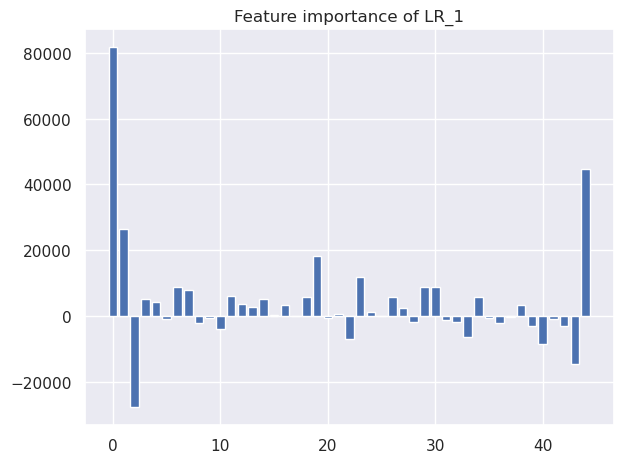

In [18]:
model.model_fi(model_1, X_train_1, y_train)

,LR_2
Feature Importance,"[70171.96542751894, 42185.730998900195, -21375..."


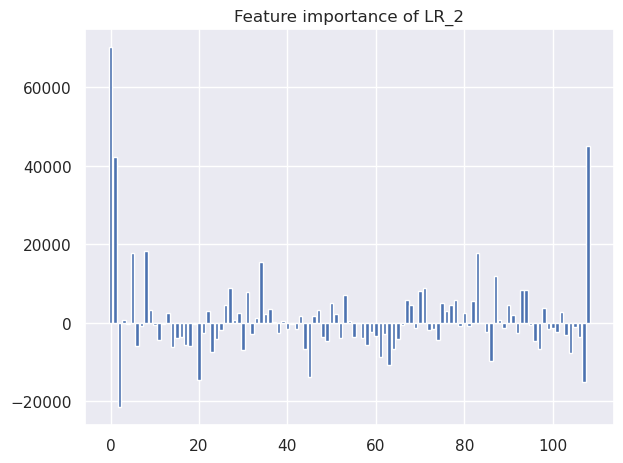

In [19]:
model.model_fi(model_2, X_train_2, y_train)

### Summary of the importance: 
### 1. Combining all the Numerical and Categorical features in Linear Regression performs much better.
### 2. 'cost', 'weight', 'product_level', 'number_of_ingredient' are important in the model.
### 3. Simple one hot encoder on 'maker' and 'product_type' is working okay, but it made the model too complicated.

### (2) Experiment on the categorical data 
### Encoding: 
- **product_level**: change to ordinal labels
- **ingredient**: count the number of ingredient, use the number as new variable

- **product_type**: one hot encoder
- **maker**: Use the three digits to reduce the categories, i.e. M14122 --> M141, then ont hot encoding
### leave the top 20 onehot encoded columns in feature importance, and drop the rest.
### Model performance is getting worse: because how dummy works for the regression is similar to the idea of binary index. The whole combination works together, reduce the columns just to reduce the information of the data.

In [21]:
type_onehot = model_2['LR_2']['preprocessor'].transformers_[2][1].get_feature_names_out()
maker_onehot = model_2['LR_2']['preprocessor'].transformers_[3][1].get_feature_names_out()
model_2_fi = pd.DataFrame(abs(model_2['LR_2']['regressor'].coef_)).iloc[3:-1]
model_2_fi.index = np.append(type_onehot, maker_onehot)

In [22]:
model_2_fi_20 = model_2_fi.sort_values(by=0, axis=0, ascending=False).iloc[0:21]
model_2_fi_20

,0
product_type_C,18289.287999
maker_new_M144M145M147,17892.224688
"product_type_B,A",17780.040394
product_type_N,15489.559568
maker_new_UnKnown,14968.197884
product_type_H,14502.047421
"product_type_Q,H",13757.518801
maker_new_M145M145,11981.957058
product_type_V,10606.814788
maker_new_M145M144,9605.831713


In [23]:
numeric_features = ['cost', 'weight']

categorical_features = ['product_level', 'ingredient_new', 'maker_new', 'product_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_level', product_level_ordinal, ['product_level']),
        ('cat_type', model.TypeDummyTransformer(), ['product_type']),
        ('cat_maker', model.MakerDummyTransformer(), ['maker_new'])
    ], remainder='passthrough'
)

step = [
    ('preprocessor', preprocessor),
    #('poly', PolynomialFeatures()), # default degree=2
    ('scaler', StandardScaler(with_mean=False)),
    ('regressor', LinearRegression())
]

features = numeric_features + categorical_features
X_train = train[features]
X_test = test[features]

models = {
    'LR_feature_changed': Pipeline(step),
}

Pipeline(step)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer())]),
                                                  ['cost', 'weight']),
                                                 ('cat_level',
                                                  OrdinalEncoder(categories=[['unrated',
                                                                              'basic',
                                                                              'intermediate',
                                                                              'advanced',
                                                                              'super '
                                                                              'advanced']]),
                                                  ['product_level']),
                                                 ('cat_type',
                                                  TypeDummyTransformer(),
                                                  ['product_type']),
                                                 ('cat_maker',
                                                  MakerDummyTransformer(),
                                                  ['maker_new'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('regressor', LinearRegression())])

In [24]:
model.model_metrics(models, X_train, X_test, y_train, y_test)

,LR_feature_changed
MAE_train,1.094358e+05
MSE_train,2.618856e+10
r2_train,3.854159e-01
MAE_test,1.394450e+05
MSE_test,5.139607e+10
r2_test,4.038347e-01


,LR_feature_changed
Feature Importance,"[86643.53761675408, 27020.436799163308, -26429..."


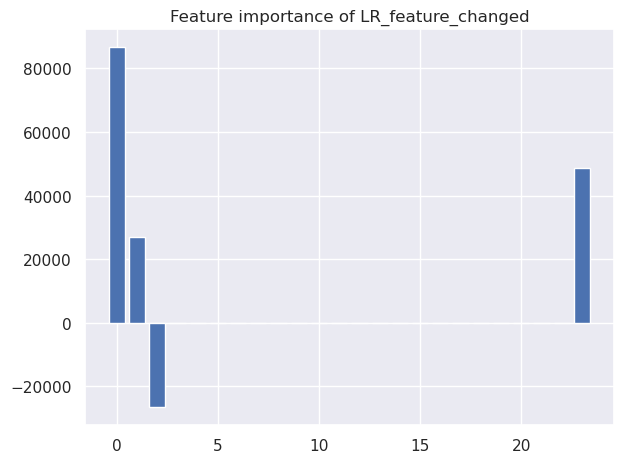

In [25]:
model.model_fi(models, X_train, y_train)

In [26]:
models['LR_feature_changed']['regressor'].coef_

array([ 86643.53761675,  27020.43679916, -26429.75435315,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,  48564.13880429])

### (3) Regession using Numerical and Categorical features
- **'cost', 'weight'**
- **product_level**: change to ordinal labels
- **ingredient**: count the number of ingredient, use the number as new variable

In [50]:
numeric_features = ['cost', 'weight']

categorical_features = ['product_level', 'ingredient_new']

product_level_ordinal = OrdinalEncoder(
    categories=[['unrated', 'basic', 'intermediate', 'advanced', 'super advanced']]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_level', product_level_ordinal, ['product_level']),
    ], remainder='passthrough'
)

step_1 = [
    ('preprocessor', preprocessor),
    #('poly', PolynomialFeatures()), # default degree=2
    ('scaler', StandardScaler(with_mean=False)),
    ('regressor', LinearRegression())
]

step_2 = [
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()), # default degree=2
    ('scaler', StandardScaler()),
    ('regressor', Lasso(max_iter=1000000, tol=1))
]

step_3 = [
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()), # default degree=2
    ('scaler', StandardScaler()),
    ('regressor', Ridge(max_iter=1000000, tol=1))
]

# tunning hyperparameters
param = {
    'poly__degree': range(2, 5),
    'regressor__alpha': np.linspace(0.1, 5, num=30)
}

features = numeric_features + categorical_features
X_train = train[features]
X_test = test[features]

models = {
    'LR_N_C': Pipeline(step_1),
    'Lasso_2_tuned': 
    model.model_tune(step_2, param, X_train, y_train).best_estimator_,
    'Ridge_2_tuned': 
    model.model_tune(step_3, param, X_train, y_train).best_estimator_
}

Pipeline(step_1)

Tunning results:  {'poly__degree': 3, 'regressor__alpha': 0.1}
Tunning results:  {'poly__degree': 2, 'regressor__alpha': 5.0}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cost', 'weight']),
                                                 ('cat_level',
                                                  OrdinalEncoder(categories=[['unrated',
                                                                              'basic',
                                                                              'intermediate',
                                                                              'advanced',
                                                                              'super '
                                                                              'advanced']]),
                                                  ['product_level'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('regressor', LinearRegression())])

In [28]:
Pipeline(step_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer())]),
                                                  ['cost', 'weight']),
                                                 ('cat_level',
                                                  OrdinalEncoder(categories=[['unrated',
                                                                              'basic',
                                                                              'intermediate',
                                                                              'advanced',
                                                                              'super '
                                                                              'advanced']]),
                                                  ['product_level'])])),
                ('poly', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('regressor', Lasso(max_iter=1000000, tol=1))])

In [29]:
Pipeline(step_3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer())]),
                                                  ['cost', 'weight']),
                                                 ('cat_level',
                                                  OrdinalEncoder(categories=[['unrated',
                                                                              'basic',
                                                                              'intermediate',
                                                                              'advanced',
                                                                              'super '
                                                                              'advanced']]),
                                                  ['product_level'])])),
                ('poly', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('regressor', Ridge(max_iter=1000000, tol=1))])

In [51]:
model_performance_4 = model.model_metrics(models, X_train, X_test, y_train, y_test)
model_performance_4

,LR_N_C,Lasso_2_tuned,Ridge_2_tuned
MAE_train,1.094358e+05,1.017878e+05,1.021606e+05
MSE_train,2.618856e+10,2.362505e+10,2.382167e+10
r2_train,3.854159e-01,4.455754e-01,4.409611e-01
MAE_test,1.394450e+05,1.275917e+05,1.278540e+05
MSE_test,5.139607e+10,4.568168e+10,4.564181e+10
r2_test,4.038347e-01,4.701184e-01,4.705808e-01


,LR_N_C,Lasso_tuned,Ridge_tuned
Feature Importance,"[86643.53761675407, 27020.436799163344, -26429...","[0.0, 105421.0789830973, 29765.663842074282, -...","[0.0, 126561.92193195627, 22896.826824374104, ..."


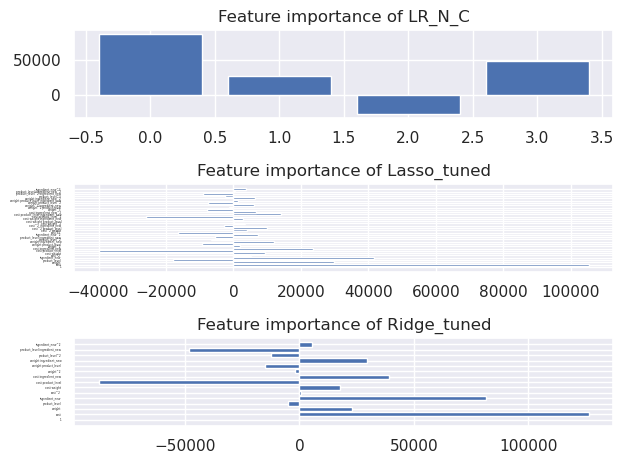

In [48]:
model.model_fi(models, X_train, y_train, features)

## 2.2 Tree models

### 2.2.1 Encode categorical variables
- **product_type**: one hot encoder
- **product_level**: change to ordinal labels
- **maker**: Use the three digits to reduce the categories, i.e. M14122 --> M141, then ont hot encoding
- **ingredient**: count the number of ingredience, use the number as new variable

- **product_type**: change to numerical labels
- **product_level**: change to ordinal labels
- **maker**: Use the three digits to reduce the categories, i.e. M14122 --> M141, then change to numerical labels
- **ingredient**: count the number of ingredience, use the number as new variable

In [32]:
df = pd.read_csv('../../data/sales.csv')
df.dropna(subset=['price'], inplace=True)
df = util.Str2NumTransform().transform(df)

df['maker_new'] = df.maker.map(util.maker_change)
df['ingredient_new'] = df.ingredient.map(util.ingredient_change)

df['year'] = pd.to_datetime(df.purchase_date).dt.year
train = df[df.year < 2015].reset_index(drop=True)
test = df[df.year >= 2015].reset_index(drop=True)
y_train = train['price']
y_test = test['price']

In [ ]:
df

### 2.2.2 Random Forest
- Combine numerical and categorical features to reveal more information.

In [33]:
numeric_features = ['cost', 'weight', 'height', 'width', 'depth']
categorical_features = ['product_level', 'product_type', 'maker_new', 'ingredient_new']

numeric_transformer = Pipeline(
    steps=[('impute', SimpleImputer(strategy='mean')),
           ('scaler', StandardScaler())]
)

product_level_ordinal = OrdinalEncoder(
    categories=[['unrated', 'basic', 'intermediate', 'advanced', 'super advanced']]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_level', product_level_ordinal, ['product_level']),
        #('cat_type', NewLabelEncoder(), 'product_type'),
        ('cat_type', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['product_type']),
        ('cat_maker', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['maker_new'])
    ], remainder='passthrough'
)

step1=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=0))
]

Pipeline(step1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cost', 'weight', 'height',
                                                   'width', 'depth']),
                                                 ('cat_level',
                                                  OrdinalEncoder(categories=[['unrated',
                                                                              'basic',
                                                                              'intermediate',
                                                                              'advanced',
                                                                              'super '
                                                                              'advanced']]),
                                                  ['product_level']),
                                                 ('cat_type',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['product_type']),
                                                 ('cat_maker',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['maker_new'])])),
                ('regressor', RandomForestRegressor(random_state=0))])

In [34]:
# tunning
param = {'regressor__n_estimators': [50, 100, 200, 300],
         'regressor__max_depth': [5, 10, 20],
         'regressor__min_samples_leaf': [20, 30, 40],
         #'regressor__max_features': [None, 'log2', 4]
        }


features = numeric_features + categorical_features
X_train = train[features]
X_test = test[features]

models = {
    'RF': Pipeline(step1),
    'RF_Tuned': model.model_tune(step1, param, X_train, y_train).best_estimator_,
}

Tunning results:  {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 20, 'regressor__n_estimators': 50}


In [35]:
model_performance_2 = model.model_metrics(models, X_train, X_test, y_train, y_test)
model_performance_2

,RF,RF_Tuned
MAE_train,3.734290e+04,9.047634e+04
MSE_train,3.438070e+09,2.086708e+10
r2_train,9.193165e-01,5.102986e-01
MAE_test,1.166826e+05,1.193084e+05
MSE_test,4.184533e+10,4.734400e+10
r2_test,5.146178e-01,4.508363e-01


,RF,RF_Tuned
Feature Importance,"[0.42612866681545025, 0.12536077960427536, 0.0...","[0.7200747282217966, 0.06083875625940006, 0.02..."


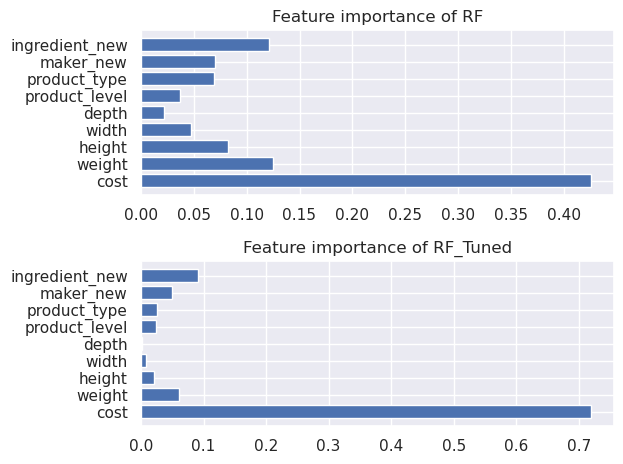

In [36]:
model.model_fi(models, X_train, y_train, features)

### 2.2.3 XGBoost
- Combine numerical and categorical features as input

In [40]:
numeric_features = ['cost', 'weight', 'height', 'width', 'depth']
numeric_transformer = Pipeline(
    steps=[('impute', SimpleImputer(strategy='mean')),
           ('scaler', StandardScaler())]
)

categorical_features = ['product_level', 'product_type', 'maker_new', 'ingredient_new']
product_level_ordinal = OrdinalEncoder(
    categories=[['unrated', 'basic', 'intermediate', 'advanced', 'super advanced']]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_level', product_level_ordinal, ['product_level']),
        #('cat_type', NewLabelEncoder(), 'product_type'),
        ('cat_type', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['product_type']),
        ('cat_maker', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['maker_new'])
    ], remainder='passthrough'
)

step2=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=0))
]

# tunning
param = {'regressor__learning_rate': [0.005, 0.01, 0.05, 0.1],
         #'regressor__gamma': [0, 0.5, 1, 1.5, 2],
         'regressor__max_depth': [3, 4, 6],
         'regressor__n_estimators': [100, 200, 300]
         #'regressor__lambda': [1, 1.5, 2],
         #'regressor__subsample': [1, 0.8]
        }

features = numeric_features + categorical_features
X_train = train[features]
X_test = test[features]

models = {
    'XGB': Pipeline(step2),
    'XGB_Tuned': model.model_tune(step2, param, X_train, y_train).best_estimator_,
}

Pipeline(step2)

Tunning results:  {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cost', 'weight', 'height',
                                                   'width', 'depth']),
                                                 ('cat_level',
                                                  OrdinalEncoder(categories=[['unrated',
                                                                              'basic',
                                                                              'intermediate',
                                                                              'advanced',
                                                                              'super '
                                                                              'advanced']]),
                                                  ['product_level']),
                                                 ('cat_type',
                                                  O...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...))])

In [41]:
model_performance_3 = model.model_metrics(models, X_train, X_test, y_train, y_test)
model_performance_3

,XGB,XGB_Tuned
MAE_train,3.052241e+04,9.062452e+04
MSE_train,2.026202e+09,1.886625e+10
r2_train,9.524498e-01,5.572532e-01
MAE_test,1.237320e+05,1.173653e+05
MSE_test,4.339479e+10,4.472820e+10
r2_test,4.966450e-01,4.811781e-01


,XGB,XGB_Tuned
Feature Importance,"[0.29358047, 0.08049628, 0.06302687, 0.0853137...","[0.40039894, 0.08072666, 0.041773003, 0.052572..."


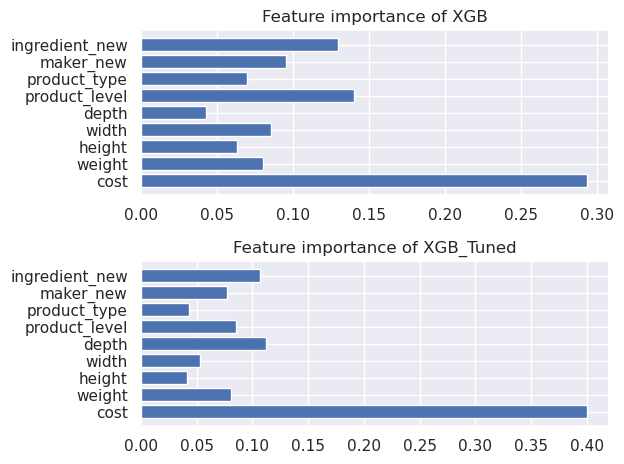

In [42]:
model.model_fi(models, X_train, y_train, features)

# 3. Summary of the Price Prediction Model

### 1. Model Performance: (1) From the metrics, XGBoost model using numerical and categorical features performs the best, but shows a little bit overfitting. (2) Linear Regression using numercial and categorical features (onehot and ordinal) perform well too. 
### 2. Feature importance: (1) for XGBoost, the 'cost' variable shows way more important than other features in predicting 'price'. (2) From Regression model, 'cost', 'weight', 'product_level', 'number of ingredient' are the most important variables. 
### -----> it gives us some thoughts about how to choose models. For this dataset, tree based models like XGBoost don't really show big difference from simple regression models; meanwhile regression models are easier to understand the relationship between features and 'price', and they can give us the direction to focus on which features. 
### So I would choose regression models for research in the early stage: Because it's easy to combine domain knowledge from other team in the same company to work more on improving the data quality and doing better feature engineering. For example, we can figure out which ingredient/maker is more important for this type of product from product team, etc. This kind of understanding is hard to get from tree based model.

#### 3. 'product_type' and 'width', 'height' are not that important to predict 'price'. We can check them for some additional information, but they can't tell too much.
#### 4. 'maker', 'ingredient', 'product_level' are able to give us some insight about how price changes. The size information of the product like 'depth', 'weight', is useful too.

In [57]:
model_performance = pd.concat(
    [model_performance_1, model_performance_2, model_performance_3, model_performance_5, model_performance_4], axis=1
)
model_performance

,Lasso_tuned,Ridge_tuned,RF,RF_Tuned,XGB,XGB_Tuned,LR_2,LR_N_C,Lasso_2_tuned,Ridge_2_tuned
MAE_train,1.114209e+05,1.082525e+05,3.734290e+04,9.047634e+04,3.052241e+04,9.062452e+04,1.018043e+05,1.094358e+05,1.017878e+05,1.021606e+05
MSE_train,2.788107e+10,2.708781e+10,3.438070e+09,2.086708e+10,2.026202e+09,1.886625e+10,2.270464e+10,2.618856e+10,2.362505e+10,2.382167e+10
r2_train,3.456966e-01,3.643126e-01,9.193165e-01,5.102986e-01,9.524498e-01,5.572532e-01,4.671753e-01,3.854159e-01,4.455754e-01,4.409611e-01
MAE_test,1.384731e+05,1.352948e+05,1.166826e+05,1.193084e+05,1.237320e+05,1.173653e+05,1.334920e+05,1.394450e+05,1.275917e+05,1.278540e+05
MSE_test,5.257221e+10,5.376591e+10,4.184533e+10,4.734400e+10,4.339479e+10,4.472820e+10,4.634105e+10,5.139607e+10,4.568168e+10,4.564181e+10
r2_test,3.901921e-01,3.763459e-01,5.146178e-01,4.508363e-01,4.966450e-01,4.811781e-01,4.624700e-01,4.038347e-01,4.701184e-01,4.705808e-01


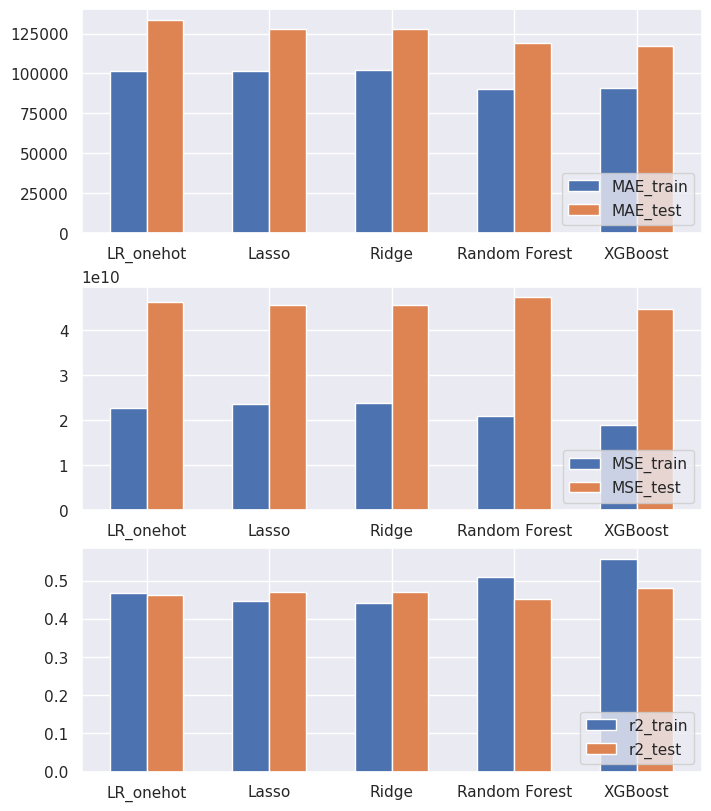

In [62]:
model_name = ['LR_onehot', 'Lasso', 'Ridge', 'Random Forest', 'XGBoost']
model.performance_compare(model_performance, model_name)